# Detecting skin ailments using CNNs
#### By: Siddhant Pattanaik

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import glob
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, Flatten, Conv2D, MaxPooling2D, AveragePooling2D

In [ ]:
# Using Google Colab with unzipped data uploaded to personal Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
#data_dir_train = pathlib.Path("https://drive.google.com/drive/folders/1fW6RggWmFsW2tL9HssDFZ7_iv7NFHzHg?usp=sharing")

data_dir_test = pathlib.Path('/content/gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Test/')
#data_dir_test = pathlib.Path('https://drive.google.com/drive/folders/1Tbok6YKvGaCIFpTp_Y-YZ2vbzsu24c9H?usp=sharing')

print("Training data path:\n", data_dir_train)

Training data path:
 /content/gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train


In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("No. of images in training data: ", image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("No. of images in testing data: ", image_count_test)

No. of images in training data:  2239
No. of images in testing data:  118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
# Import required library
from tensorflow.keras.utils import image_dataset_from_directory

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = image_dataset_from_directory(data_dir_train, labels='inferred', label_mode='categorical', 
                                        batch_size = batch_size, image_size=(img_height,img_width),
                                        shuffle=True, seed = 123, validation_split=0.2, subset='training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = image_dataset_from_directory(data_dir_train, labels='inferred', label_mode='categorical', 
                                      batch_size = batch_size, image_size=(img_height,img_width),
                                      shuffle=True, seed = 123, validation_split=0.2, subset='validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [ ]:
print(val_ds.class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Basic EDA

Let's do some basic EDA to see the distribution of data.


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
# Creating a dataframe of the image files and their corresponding labels to check the distribution of the data
df_images = pd.DataFrame(columns=["Image_Name","Label"])
for clas in class_names:
  path_class = str(data_dir_train) + '/' + clas + '/'
  all_files = os.listdir(path_class)
  files = []
  for fil in all_files:
    if '.jpg' in fil:
      files.append(fil)
    else:
      None
  l = len(files)
  labels = [clas for i in range(l)]
  temp_df = pd.DataFrame({"Image_Name":files,"Label":labels})
  df_images = pd.concat([df_images,temp_df])
df_images.shape

(2239, 2)

In [ ]:
df_images.head()

,Image_Name,Label
0,ISIC_0026525.jpg,actinic keratosis
1,ISIC_0025780.jpg,actinic keratosis
2,ISIC_0028190.jpg,actinic keratosis
3,ISIC_0029840.jpg,actinic keratosis
4,ISIC_0025803.jpg,actinic keratosis


In [ ]:
# Checking the distribution of each class, first in numbers
print("Class distribution in training data:\n")
df_images.Label.value_counts().sort_index()

Class distribution in training data:



actinic keratosis             114
basal cell carcinoma          376
dermatofibroma                 95
melanoma                      438
nevus                         357
pigmented benign keratosis    462
seborrheic keratosis           77
squamous cell carcinoma       181
vascular lesion               139
Name: Label, dtype: int64

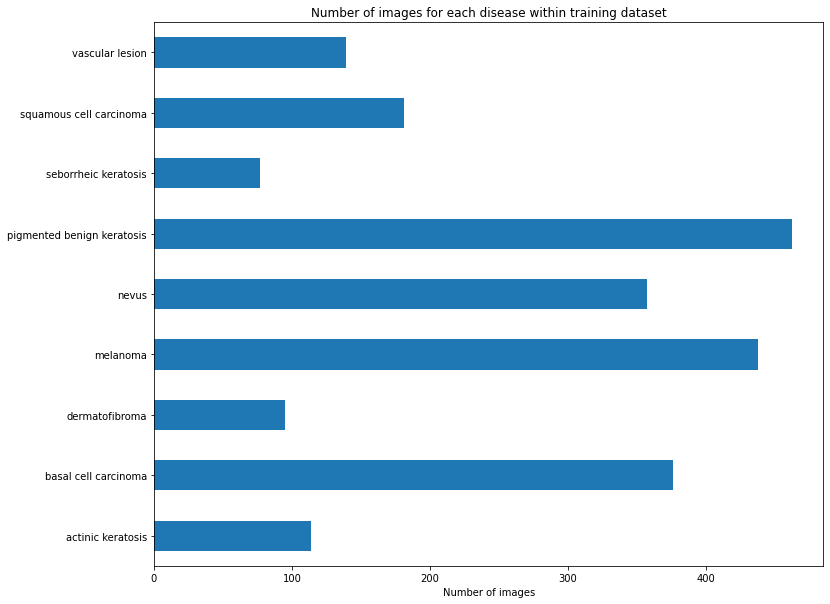

In [ ]:
# Plotting a bar chart of the class distribution
plt.figure(figsize=(12,10))
df_images.Label.value_counts().sort_index().plot.barh()
plt.title("Number of images for each disease within training dataset")
plt.xlabel("Number of images")
plt.show()

#### EDA conclusions
- We can see some class imbalance in the dataset, with some classes having much larger number of datapoints than others.
- This may affect the training process and would have to be checked if balancing the class weights helps in the training process.

### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

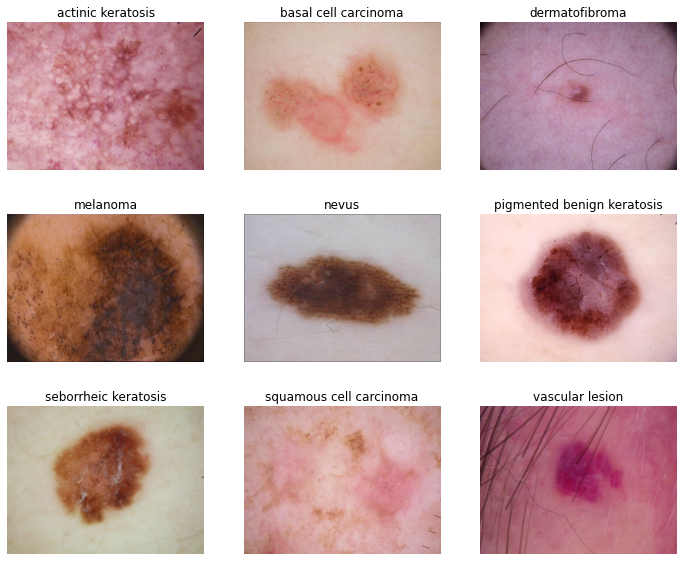

In [ ]:
# Let's display 9 images from the training set, 1 random image from each folder by reading the train directory
plt.figure(figsize=(12,10))
for i in range(9):
  ax = plt.subplot(3,3,i+1)
  rand_idx = np.random.randint(low=1, high=50)
  im = mpimg.imread(str(list(data_dir_train.glob(class_names[i]+ '/*.jpg'))[rand_idx]))
  plt.imshow(im)
  plt.title(class_names[i])
  plt.axis("off")
plt.show()

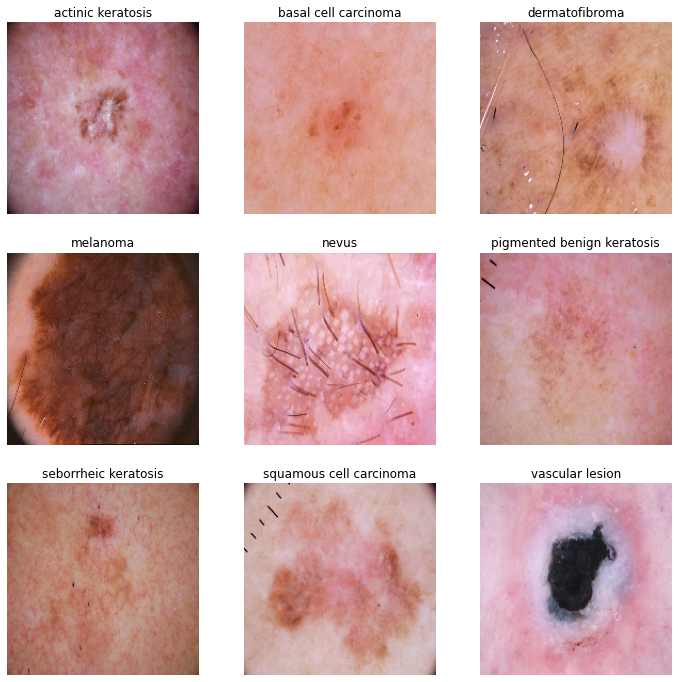

In [ ]:
# Since the dataset has been resized during import into a tensorflow dataset, let's see samples from each disease in the tensorflow training dataset as well.
fig = plt.figure(figsize = (12,12))
for i in range(9): 
  for images,labels in train_ds.take(50):
    if tf.where(labels[i]>0).numpy()[0] == i:
      idx = tf.where(labels[i]>0).numpy()[0]
      ax = plt.subplot(3, 3, i+1)
      plt.imshow(images[i].numpy().astype('uint8'))
      plt.title(class_names[idx[0]])
      plt.axis('off')
      break
    else:
      continue
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

In [ ]:
# Let's double check the batch sizes
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32, 9)


### Normalize training and validation data

In [ ]:
# Defining a normalization layer
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
# Applying normalization to training data
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(train_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
# Applying normalization to validation data
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(val_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.014221026 0.99915177


`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
# Configuring the dataset for performance, so that I/O does not become a bottleneck
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

In [ ]:
# Define number of classes
num_classes = 9

### Model 1

- Initial base model with 3 convolution layers and 1 fully-connected layer to check results

Architecture:
- Input as per image shape and channels.
- Conv2D(16)
- Max_Pooling(2x2)
- Conv2D(32)
- Max_Pooling(2x2)
- Conv2D(64)
- Max_Pooling(2x2)
- Fully Connected layer (128)
- Softmax output layer (9 classes)
- Optimizer: 'sgd'
- Loss: 'categorical_crossentropy'

In [ ]:
# Model 1
# Initial base model with 3 convolution layers and 1 fully-connected layer to check results

model1 = Sequential([layers.Layer(input_shape = (img_height, img_width, 3))])

model1.add(Conv2D(16, kernel_size=(3,3), padding ='same', activation = 'relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Conv2D(32, kernel_size=(3,3), padding ='same', activation = 'relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Conv2D(64, kernel_size=(3,3), padding ='same', activation = 'relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Flatten())
model1.add(Dense(128, activation = 'relu'))

model1.add(Dense(num_classes, activation = 'softmax'))

# View the summary of all layers
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer (Layer)                (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [ ]:
# Compiling model 1
model1.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Fitting model 1
epochs = 20
history1 = model1.fit(train_ds, 
                      validation_data=val_ds,
                      epochs=epochs, 
                      verbose = 1, shuffle = True)

Epoch 1/20
56/56 [==============================] - 292s 841ms/step - loss: 2.0455 - accuracy: 0.1975 - val_loss: 2.0369 - val_accuracy: 0.1879
Epoch 2/20
56/56 [==============================] - 2s 42ms/step - loss: 2.0236 - accuracy: 0.2081 - val_loss: 2.0029 - val_accuracy: 0.2528
Epoch 3/20
56/56 [==============================] - 2s 40ms/step - loss: 2.0006 - accuracy: 0.2506 - val_loss: 1.9765 - val_accuracy: 0.2841
Epoch 4/20
56/56 [==============================] - 2s 41ms/step - loss: 1.9752 - accuracy: 0.2768 - val_loss: 1.9912 - val_accuracy: 0.2595
Epoch 5/20
56/56 [==============================] - 2s 40ms/step - loss: 1.9496 - accuracy: 0.2773 - val_loss: 1.9014 - val_accuracy: 0.2685
Epoch 6/20
56/56 [==============================] - 2s 41ms/step - loss: 1.9238 - accuracy: 0.2946 - val_loss: 1.8783 - val_accuracy: 0.2774
Epoch 7/20
56/56 [==============================] - 2s 40ms/step - loss: 1.8877 - accuracy: 0.3175 - val_loss: 1.8289 - val_accuracy: 0.3870
Epoch 8/20

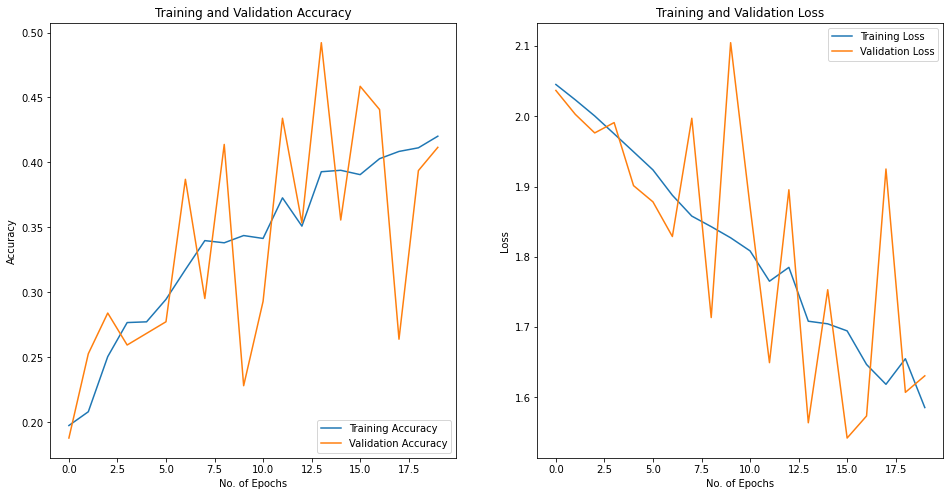

In [ ]:
# Plotting the results
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy")
plt.xlabel("No. of Epochs")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss")
plt.xlabel("No. of Epochs")

plt.show()

#### Model 1 results after 20 epochs

*   Training accuracy: 0.4202
*   Validation accuracy: 0.4116

- The accuracy values are mostly increasing monotonically. The loss values are also mostly decreasing monotonically, which is good
- The training is also rather slow with 'sgd' optimizer and not great results after 20 epochs. It might be a good idea to use a different optimizer like 'adam'

### Model 2

- Same as model 1, but using 'adam' optimizer instead

- Input as per image shape and channels.
- Conv2D(16)
- Max_Pooling(2x2)
- Conv2D(32)
- Max_Pooling(2x2)
- Conv2D(64)
- Max_Pooling(2x2)
- Fully Connected layer (128)
- Softmax output layer (9 classes)
- Optimizer: 'adam'
- Loss: 'categorical_crossentropy'

In [ ]:
# Model 2
# Same as model 1, but using 'adam' optimizer instead

model2 = Sequential([layers.Layer(input_shape = (img_height, img_width, 3))])

model2.add(Conv2D(16, kernel_size=(3,3), padding ='same', activation = 'relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Conv2D(32, kernel_size=(3,3), padding ='same', activation = 'relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Conv2D(64, kernel_size=(3,3), padding ='same', activation = 'relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Flatten())
model2.add(Dense(128, activation = 'relu'))
model2.add(Dense(num_classes, activation = 'softmax'))

# View the summary of all layers
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (Layer)              (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 22, 22, 64)       

In [ ]:
# Compiling model 2
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Fitting model 2
epochs = 20
history2 = model2.fit(train_ds, 
                      validation_data=val_ds,
                      epochs=epochs, 
                      verbose = 1, shuffle = True)

Epoch 1/20
56/56 [==============================] - 3s 45ms/step - loss: 2.0243 - accuracy: 0.2489 - val_loss: 1.7773 - val_accuracy: 0.3311
Epoch 2/20
56/56 [==============================] - 2s 42ms/step - loss: 1.6524 - accuracy: 0.4090 - val_loss: 1.5858 - val_accuracy: 0.4631
Epoch 3/20
56/56 [==============================] - 2s 41ms/step - loss: 1.4777 - accuracy: 0.4916 - val_loss: 1.3817 - val_accuracy: 0.5436
Epoch 4/20
56/56 [==============================] - 2s 41ms/step - loss: 1.3351 - accuracy: 0.5329 - val_loss: 1.3524 - val_accuracy: 0.5414
Epoch 5/20
56/56 [==============================] - 2s 41ms/step - loss: 1.3033 - accuracy: 0.5424 - val_loss: 1.3503 - val_accuracy: 0.5324
Epoch 6/20
56/56 [==============================] - 2s 41ms/step - loss: 1.1580 - accuracy: 0.5932 - val_loss: 1.3824 - val_accuracy: 0.5369
Epoch 7/20
56/56 [==============================] - 2s 41ms/step - loss: 1.1253 - accuracy: 0.6010 - val_loss: 1.3553 - val_accuracy: 0.5638
Epoch 8/20
56

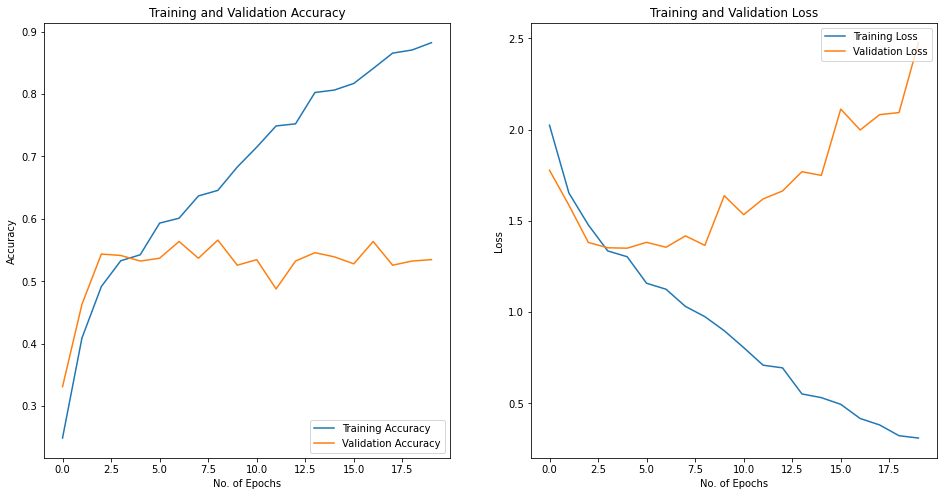

In [ ]:
# Plotting the results
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy")
plt.xlabel("No. of Epochs")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss")
plt.xlabel("No. of Epochs")

plt.show()

#### Model 2 results after 20 epochs

*   Training accuracy: 0.8823
*   Validation accuracy: 0.5347

- The training converges much faster now.
- However, the validation accuracy plateaus at about 0.55 after a few epochs.
- The wide gulf between training and validation accuracy is a clear sign of overfitting.


### Model 3

- Adding a convolutional layer to model 2

Architecture
- Input as per image shape and channels.
- Conv2D(16)
- Max_Pooling(2x2)
- Conv2D(32)
- Max_Pooling(2x2)
- Conv2D(64)
- Max_Pooling(2x2)
- Conv2D(128)
- Max_Pooling(2x2)
- Fully Connected layer (256)
- Softmax output layer (9 classes)
- Optimizer: 'adam'
- Loss: 'categorical_crossentropy'

In [ ]:
# Model 3
# Additional convolution layer added to model 2 to see if results improve.

model3 = Sequential([layers.Layer(input_shape = (img_height, img_width, 3))])
model3.add(Conv2D(16, kernel_size=(3,3), padding ='same', activation = 'relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))

model3.add(Conv2D(32, kernel_size=(3,3), padding ='same', activation = 'relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))

model3.add(Conv2D(64, kernel_size=(3,3), padding ='same', activation = 'relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))

model3.add(Conv2D(128, kernel_size=(3,3), padding ='same', activation = 'relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))

model3.add(Flatten())
model3.add(Dense(256, activation = 'relu'))

model3.add(Dense(num_classes, activation = 'softmax'))

# View the summary of all layers
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_2 (Layer)              (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 22, 22, 64)       

In [ ]:
# Compiling model 3 with optimizer 'adam'
model3.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Fitting model 3
epochs = 20
history3 = model3.fit(train_ds, 
                      validation_data=val_ds,
                      epochs=epochs, 
                      verbose = 1, shuffle = True)

Epoch 1/20
56/56 [==============================] - 4s 51ms/step - loss: 2.1015 - accuracy: 0.1975 - val_loss: 2.0429 - val_accuracy: 0.2260
Epoch 2/20
56/56 [==============================] - 3s 45ms/step - loss: 2.0019 - accuracy: 0.2394 - val_loss: 1.9828 - val_accuracy: 0.2729
Epoch 3/20
56/56 [==============================] - 3s 45ms/step - loss: 1.8117 - accuracy: 0.3465 - val_loss: 1.6098 - val_accuracy: 0.4251
Epoch 4/20
56/56 [==============================] - 3s 45ms/step - loss: 1.5576 - accuracy: 0.4554 - val_loss: 1.4800 - val_accuracy: 0.5168
Epoch 5/20
56/56 [==============================] - 3s 45ms/step - loss: 1.4295 - accuracy: 0.4983 - val_loss: 1.4350 - val_accuracy: 0.5235
Epoch 6/20
56/56 [==============================] - 3s 45ms/step - loss: 1.4557 - accuracy: 0.4911 - val_loss: 1.6352 - val_accuracy: 0.4787
Epoch 7/20
56/56 [==============================] - 3s 45ms/step - loss: 1.3114 - accuracy: 0.5452 - val_loss: 1.4091 - val_accuracy: 0.5302
Epoch 8/20
56

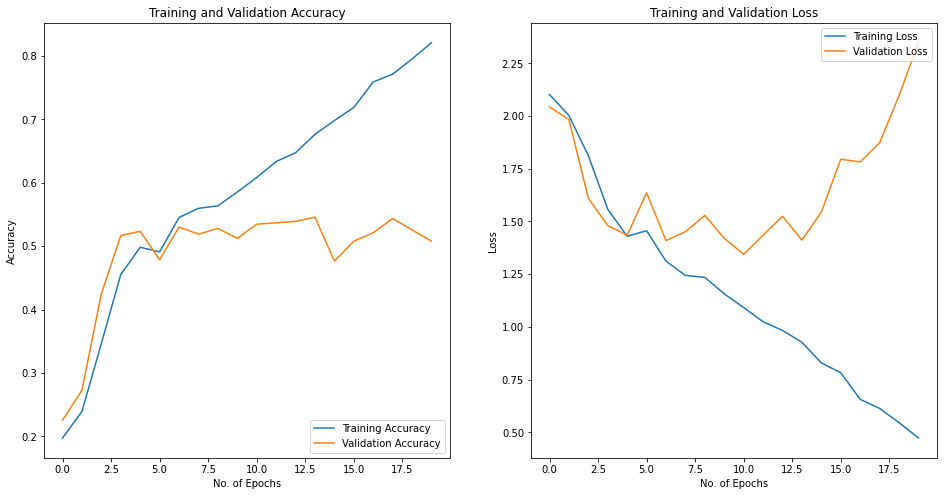

In [ ]:
# Plotting the results
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy")
plt.xlabel("No. of Epochs")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss")
plt.xlabel("No. of Epochs")

plt.show()

#### Model 3 results after 20 epochs

*   Training accuracy: 0.8209
*   Validation accuracy: 0.5078

- As with the earlier model, there are clear signs of overfitting. 
- The validation accuracy is rather stagnant at about 0.5 - 0.55.

### Model 4

- Additional fully connected layer included over model 2 architecture.

Architecture
- Input as per image shape and channels.
- Conv2D(16)
- Max_Pooling(2x2)
- Conv2D(32)
- Max_Pooling(2x2)
- Conv2D(64)
- Max_Pooling(2x2)
- Conv2D(128)
- Max_Pooling(2x2)
- Fully Connected layer (128)
- Fully Connected layer (256)
- Softmax output layer (9 classes)
- Optimizer: 'adam'
- Loss: 'categorical_crossentropy'

In [ ]:
# Model 4
# Additional fully connected layer included over model 2 architecture.

model4 = Sequential([layers.Layer(input_shape = (img_height, img_width, 3))])
model4.add(Conv2D(16, kernel_size=(3,3), padding ='same', activation = 'relu'))
model4.add(MaxPooling2D(pool_size=(2,2)))

model4.add(Conv2D(32, kernel_size=(3,3), padding ='same', activation = 'relu'))
model4.add(MaxPooling2D(pool_size=(2,2)))

model4.add(Conv2D(64, kernel_size=(3,3), padding ='same', activation = 'relu'))
model4.add(MaxPooling2D(pool_size=(2,2)))

model4.add(Flatten())
model4.add(Dense(128, activation = 'relu'))
model4.add(Dense(256, activation = 'relu'))
model4.add(Dense(num_classes, activation = 'softmax'))

# View the summary of all layers
model4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_3 (Layer)              (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 22, 22, 64)       

In [ ]:
# Compiling model 4
model4.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Fitting model 4
epochs = 20
history4 = model4.fit(train_ds, 
                      validation_data=val_ds,
                      epochs=epochs, 
                      verbose = 1, shuffle = True)

Epoch 1/20
56/56 [==============================] - 3s 46ms/step - loss: 1.9937 - accuracy: 0.2394 - val_loss: 1.8334 - val_accuracy: 0.3154
Epoch 2/20
56/56 [==============================] - 2s 41ms/step - loss: 1.6785 - accuracy: 0.3884 - val_loss: 1.5527 - val_accuracy: 0.4541
Epoch 3/20
56/56 [==============================] - 2s 42ms/step - loss: 1.5093 - accuracy: 0.4688 - val_loss: 1.4234 - val_accuracy: 0.5034
Epoch 4/20
56/56 [==============================] - 2s 42ms/step - loss: 1.4619 - accuracy: 0.4810 - val_loss: 1.3345 - val_accuracy: 0.5503
Epoch 5/20
56/56 [==============================] - 2s 41ms/step - loss: 1.2701 - accuracy: 0.5597 - val_loss: 1.3168 - val_accuracy: 0.5593
Epoch 6/20
56/56 [==============================] - 2s 41ms/step - loss: 1.1659 - accuracy: 0.5938 - val_loss: 1.4043 - val_accuracy: 0.5101
Epoch 7/20
56/56 [==============================] - 2s 41ms/step - loss: 1.0703 - accuracy: 0.6239 - val_loss: 1.4542 - val_accuracy: 0.5347
Epoch 8/20
56

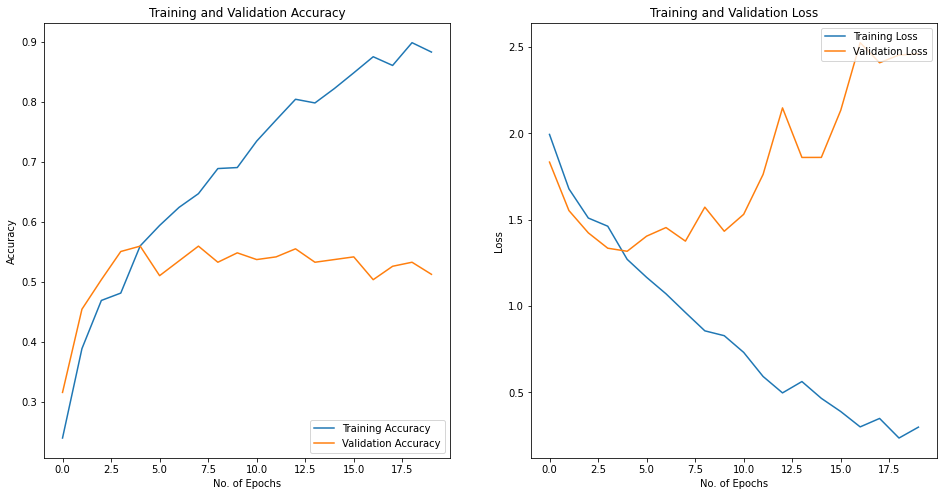

In [ ]:
# Plotting the results
acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']

loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy")
plt.xlabel("No. of Epochs")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss")
plt.xlabel("No. of Epochs")

plt.show()

#### Model 4 results after 20 epochs

*   Training accuracy: 0.8828
*   Validation accuracy: 0.5123

- As with model 3, the validation accuracy has plateaud around 0.5 while the training accuracy is at 0.88. Clear signs of overfitting and requirement of some form of regularization.

### Model 5

- Same as model 2, but with a wider network (increased no. of features) for all layers.

Architecture
- Input as per image shape and channels.
- Conv2D(32)
- Max_Pooling(2x2)
- Conv2D(64)
- Max_Pooling(2x2)
- Conv2D(128)
- Max_Pooling(2x2)
- Fully Connected layer (256)
- Softmax output layer (9 classes)
- Optimizer: 'adam'
- Loss: 'categorical_crossentropy'

In [ ]:
# Model 5
# Same as model 2, but with a wider network (increased no. of features) for all layers.

model5 = Sequential([layers.Layer(input_shape = (img_height, img_width, 3))])
model5.add(Conv2D(32, kernel_size=(3,3), padding ='same', activation = 'relu'))
model5.add(MaxPooling2D(pool_size=(2,2)))

model5.add(Conv2D(64, kernel_size=(3,3), padding ='same', activation = 'relu'))
model5.add(MaxPooling2D(pool_size=(2,2)))

model5.add(Conv2D(128, kernel_size=(3,3), padding ='same', activation = 'relu'))
model5.add(MaxPooling2D(pool_size=(2,2)))

model5.add(Flatten())
model5.add(Dense(256, activation = 'relu'))
model5.add(Dense(num_classes, activation = 'softmax'))

# View the summary of all layers
model5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_4 (Layer)              (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 90, 90, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 45, 45, 128)       73856     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 22, 22, 128)      

In [ ]:
# Compiling model 5
model5.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Fitting model 5
epochs = 20
history5 = model5.fit(train_ds, 
                      validation_data=val_ds,
                      epochs=epochs, 
                      verbose = 1, shuffle = True)

Epoch 1/20
56/56 [==============================] - 6s 83ms/step - loss: 2.0932 - accuracy: 0.2612 - val_loss: 1.9198 - val_accuracy: 0.2819
Epoch 2/20
56/56 [==============================] - 4s 74ms/step - loss: 1.5945 - accuracy: 0.4252 - val_loss: 1.6626 - val_accuracy: 0.4004
Epoch 3/20
56/56 [==============================] - 4s 74ms/step - loss: 1.4667 - accuracy: 0.4860 - val_loss: 1.4022 - val_accuracy: 0.5235
Epoch 4/20
56/56 [==============================] - 4s 73ms/step - loss: 1.3704 - accuracy: 0.5324 - val_loss: 1.4131 - val_accuracy: 0.5235
Epoch 5/20
56/56 [==============================] - 4s 73ms/step - loss: 1.2960 - accuracy: 0.5374 - val_loss: 1.4531 - val_accuracy: 0.5034
Epoch 6/20
56/56 [==============================] - 4s 73ms/step - loss: 1.1812 - accuracy: 0.5854 - val_loss: 1.4376 - val_accuracy: 0.5280
Epoch 7/20
56/56 [==============================] - 4s 75ms/step - loss: 1.1058 - accuracy: 0.6077 - val_loss: 1.5723 - val_accuracy: 0.5034
Epoch 8/20
56

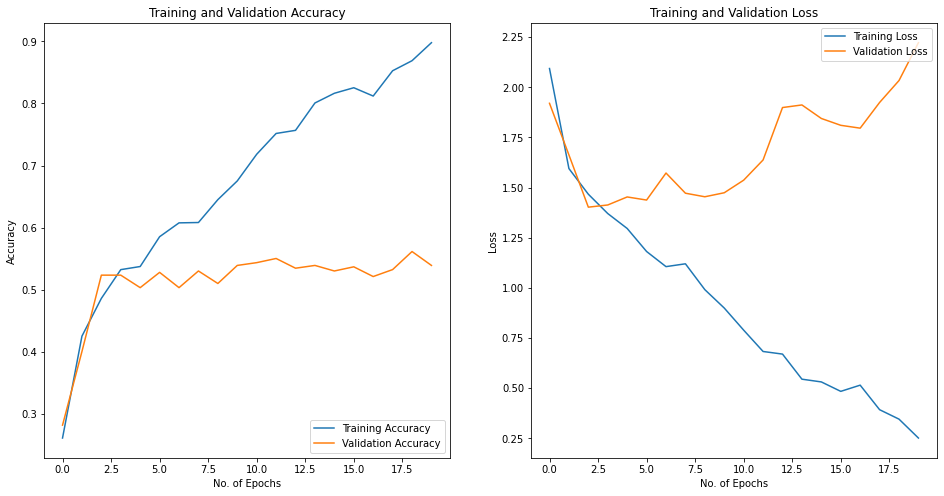

In [ ]:
# Plotting the results
acc = history5.history['accuracy']
val_acc = history5.history['val_accuracy']

loss = history5.history['loss']
val_loss = history5.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy")
plt.xlabel("No. of Epochs")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss")
plt.xlabel("No. of Epochs")

plt.show()

#### Model 5 results after 20 epochs

*   Training accuracy: 0.8979
*   Validation accuracy: 0.5391

- Increasing the number of features does not help in improving the validation accuracy in any way. 
- Significant overfitting still remains as with other models.

### Model 6

Same as model 2, but with batch_normalization enabled after each hidden layer

Architecture:
- Input as per image shape and channels.
- Conv2D(16)
- Batch Norm
- Max_Pooling(2x2)
- Conv2D(32)
- Batch Norm
- Max_Pooling(2x2)
- Conv2D(64)
- Batch Norm
- Max_Pooling(2x2)
- Fully Connected layer (128)
- Softmax output layer (9 classes)
- Optimizer: 'adam'
- Loss: 'categorical_crossentropy'

In [ ]:
# Model 6
# Same as model 2, but with batch_normalization enabled after each hidden layer

model6 = Sequential([layers.Layer(input_shape = (img_height, img_width, 3))])
model6.add(Conv2D(16, kernel_size=(3,3), padding ='same', activation = 'relu'))
model6.add(BatchNormalization())
model6.add(MaxPooling2D(pool_size=(2,2)))

model6.add(Conv2D(32, kernel_size=(3,3), padding ='same', activation = 'relu'))
model6.add(BatchNormalization())
model6.add(MaxPooling2D(pool_size=(2,2)))

model6.add(Conv2D(64, kernel_size=(3,3), padding ='same', activation = 'relu'))
model6.add(BatchNormalization())
model6.add(MaxPooling2D(pool_size=(2,2)))

model6.add(Flatten())
model6.add(Dense(128, activation = 'relu'))
model6.add(BatchNormalization())
model6.add(Dense(num_classes, activation = 'softmax'))

# View the summary of all layers
model6.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_5 (Layer)              (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 180, 180, 16)      64        
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 90, 90, 32)        128       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 45, 45, 32)       

In [ ]:
# Compiling model 6
model6.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Fitting model 6
epochs = 20
history6 = model6.fit(train_ds, 
                      validation_data=val_ds,
                      epochs=epochs, 
                      verbose = 1, shuffle = True)

Epoch 1/20
56/56 [==============================] - 4s 55ms/step - loss: 1.6915 - accuracy: 0.4609 - val_loss: 5.2079 - val_accuracy: 0.0537
Epoch 2/20
56/56 [==============================] - 3s 51ms/step - loss: 1.2219 - accuracy: 0.5865 - val_loss: 12.8395 - val_accuracy: 0.0537
Epoch 3/20
56/56 [==============================] - 3s 51ms/step - loss: 1.0134 - accuracy: 0.6562 - val_loss: 17.6782 - val_accuracy: 0.0537
Epoch 4/20
56/56 [==============================] - 3s 51ms/step - loss: 0.8645 - accuracy: 0.7121 - val_loss: 16.5093 - val_accuracy: 0.0537
Epoch 5/20
56/56 [==============================] - 3s 51ms/step - loss: 0.7672 - accuracy: 0.7411 - val_loss: 10.9733 - val_accuracy: 0.0559
Epoch 6/20
56/56 [==============================] - 3s 51ms/step - loss: 0.5981 - accuracy: 0.8008 - val_loss: 6.0044 - val_accuracy: 0.1186
Epoch 7/20
56/56 [==============================] - 3s 51ms/step - loss: 0.4427 - accuracy: 0.8650 - val_loss: 4.9903 - val_accuracy: 0.1387
Epoch 8/2

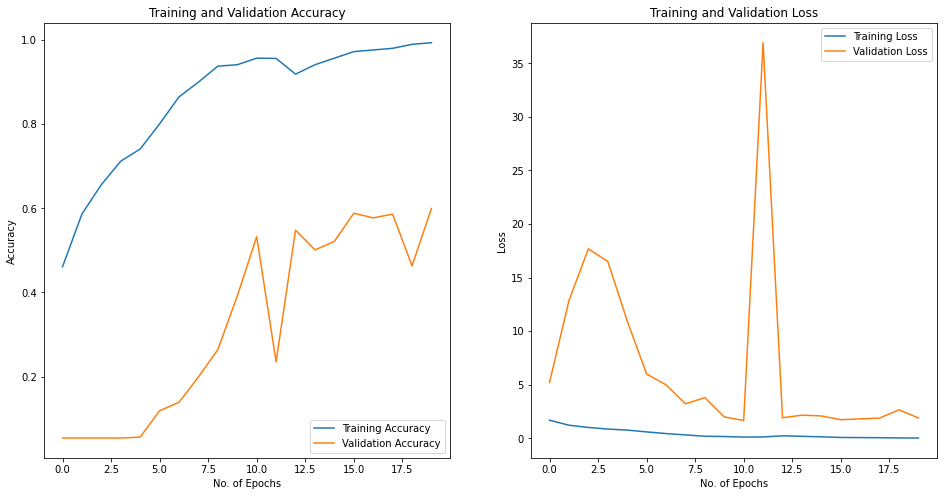

In [ ]:
# Plotting the results
acc = history6.history['accuracy']
val_acc = history6.history['val_accuracy']

loss = history6.history['loss']
val_loss = history6.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy")
plt.xlabel("No. of Epochs")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss")
plt.xlabel("No. of Epochs")

plt.show()

#### Model 6 results after 20 epochs

*   Training accuracy: 0.9939
*   Validation accuracy: 0.5996

- The training accuracy increases very quickly compared to earlier models.
- There is still significant overfitting observed and appropriate regularization strategies need to be implemented to address this.

## Adding Regularization to the model

- **For the next few models, a few regularization strategies have been attempted to try and address the overfitting issues observed in the earlier models**

### Model 7

- Same as model 6, but with dropout layers added after convolutional layers and Fully Connected Layer.

Architecture:
- Input as per image shape and channels.
- Conv2D(16)
- Batch Norm
- Max_Pooling(2x2)
- Dropout(0.1)
- Conv2D(32)
- Batch Norm
- Max_Pooling(2x2)
- Dropout(0.1)
- Conv2D(64)
- Batch Norm
- Max_Pooling(2x2)
- Dropout(0.2)
- Fully Connected layer (128)
- Batch Norm
- Dropout (0.5)
- Softmax output layer (9 classes)
- Optimizer: 'adam'
- Loss: 'categorical_crossentropy'

In [ ]:
# Model 7
# Same as model 6, but with dropout layers added after convolutional layers and Fully Connected layer.

model7 = Sequential([layers.Layer(input_shape = (img_height, img_width, 3))])

model7.add(Conv2D(16, kernel_size=(3,3), padding ='same', activation = 'relu'))
model7.add(BatchNormalization())
model7.add(MaxPooling2D(pool_size=(2,2)))
model7.add(Dropout(0.1))

model7.add(Conv2D(32, kernel_size=(3,3), padding ='same', activation = 'relu'))
model7.add(BatchNormalization())
model7.add(MaxPooling2D(pool_size=(2,2)))
model7.add(Dropout(0.1))

model7.add(Conv2D(64, kernel_size=(3,3), padding ='same', activation = 'relu'))
model7.add(BatchNormalization())
model7.add(MaxPooling2D(pool_size=(2,2)))
model7.add(Dropout(0.2))

model7.add(Flatten())
model7.add(Dense(128, activation = 'relu'))
model7.add(BatchNormalization())
model7.add(Dropout(0.5))
model7.add(Dense(num_classes, activation = 'softmax'))

# View the summary of all layers
model7.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_6 (Layer)              (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
batch_normalization_4 (Batch (None, 180, 180, 16)      64        
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
batch_normalization_5 (Batch (None, 90, 90, 32)       

In [ ]:
# Compiling model 7
model7.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Fitting model 7
epochs = 20
history7 = model7.fit(train_ds, 
                      validation_data=val_ds,
                      epochs=epochs, 
                      verbose = 1, shuffle = True)

Epoch 1/20
56/56 [==============================] - 4s 61ms/step - loss: 2.2018 - accuracy: 0.3387 - val_loss: 3.0863 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 3s 55ms/step - loss: 1.7039 - accuracy: 0.4632 - val_loss: 3.8899 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 3s 55ms/step - loss: 1.5043 - accuracy: 0.4994 - val_loss: 4.4888 - val_accuracy: 0.1499
Epoch 4/20
56/56 [==============================] - 3s 55ms/step - loss: 1.4055 - accuracy: 0.5251 - val_loss: 6.0923 - val_accuracy: 0.0403
Epoch 5/20
56/56 [==============================] - 3s 55ms/step - loss: 1.2717 - accuracy: 0.5737 - val_loss: 6.5089 - val_accuracy: 0.0872
Epoch 6/20
56/56 [==============================] - 3s 55ms/step - loss: 1.2310 - accuracy: 0.5837 - val_loss: 6.7120 - val_accuracy: 0.0783
Epoch 7/20
56/56 [==============================] - 3s 55ms/step - loss: 1.1119 - accuracy: 0.6194 - val_loss: 6.3401 - val_accuracy: 0.1208
Epoch 8/20
56

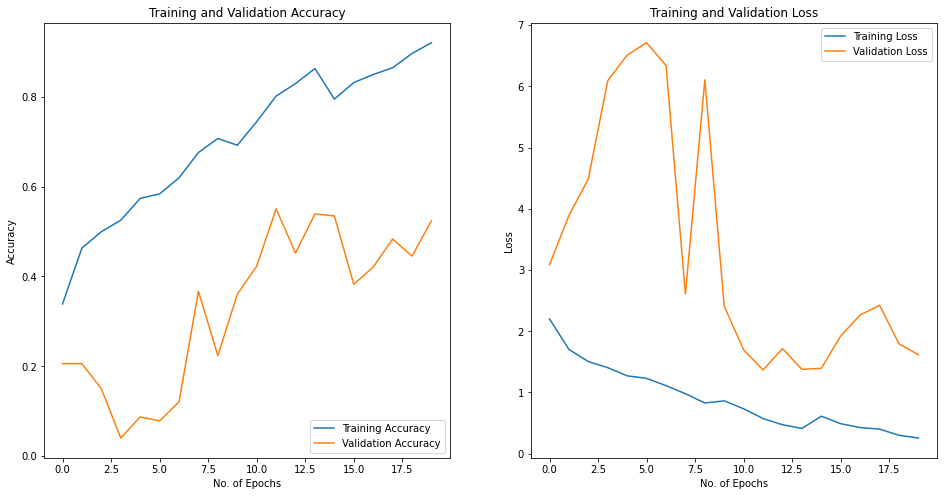

In [ ]:
# Plotting the results
acc = history7.history['accuracy']
val_acc = history7.history['val_accuracy']

loss = history7.history['loss']
val_loss = history7.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy")
plt.xlabel("No. of Epochs")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss")
plt.xlabel("No. of Epochs")

plt.show()

#### Model 7 results after 20 epochs

*   Training accuracy: 0.9202
*   Validation accuracy: 0.5235

- Overfitting is still an issue even with dropouts included.
- Harsher regularization measures required.

### Model 8

- Same as model 7, but with harsher dropout params

Architecture:
- Input as per image shape and channels.
- Conv2D(16)
- Batch Norm
- Max_Pooling(2x2)
- Dropout(0.2)
- Conv2D(32)
- Batch Norm
- Max_Pooling(2x2)
- Dropout(0.2)
- Conv2D(64)
- Batch Norm
- Max_Pooling(2x2)
- Dropout(0.3)
- Fully Connected layer (128)
- Batch Norm
- Dropout (0.5)
- Softmax output layer (9 classes)
- Optimizer: 'adam'
- Loss: 'categorical_crossentropy'

In [ ]:
# Model 8
# Same as model 7, but with harsher dropout parameters

model8 = Sequential([layers.Layer(input_shape = (img_height, img_width, 3))])

model8.add(Conv2D(16, kernel_size=(3,3), padding ='same', activation = 'relu'))
model8.add(BatchNormalization())
model8.add(MaxPooling2D(pool_size=(2,2)))
model8.add(Dropout(0.2))

model8.add(Conv2D(32, kernel_size=(3,3), padding ='same', activation = 'relu'))
model8.add(BatchNormalization())
model8.add(MaxPooling2D(pool_size=(2,2)))
model8.add(Dropout(0.2))

model8.add(Conv2D(64, kernel_size=(3,3), padding ='same', activation = 'relu'))
model8.add(BatchNormalization())
model8.add(MaxPooling2D(pool_size=(2,2)))
model8.add(Dropout(0.3))

model8.add(Flatten())
model8.add(Dense(128, activation = 'relu'))
model8.add(BatchNormalization())
model8.add(Dropout(0.5))
model8.add(Dense(num_classes, activation = 'softmax'))

# View the summary of all layers
model8.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_17 (Layer)             (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
batch_normalization_41 (Batc (None, 180, 180, 16)      64        
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
dropout_43 (Dropout)         (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
batch_normalization_42 (Batc (None, 90, 90, 32)      

In [ ]:
# Compiling model 8
model8.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Fitting model 8
epochs = 20
history8 = model8.fit(train_ds, 
                      validation_data=val_ds,
                      epochs=epochs, 
                      verbose = 1, shuffle = True)

Epoch 1/20
56/56 [==============================] - 4s 61ms/step - loss: 2.1893 - accuracy: 0.3488 - val_loss: 12.1659 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 3s 55ms/step - loss: 1.6569 - accuracy: 0.4542 - val_loss: 23.1562 - val_accuracy: 0.1499
Epoch 3/20
56/56 [==============================] - 3s 56ms/step - loss: 1.5564 - accuracy: 0.4721 - val_loss: 32.1965 - val_accuracy: 0.1499
Epoch 4/20
56/56 [==============================] - 3s 56ms/step - loss: 1.3338 - accuracy: 0.5491 - val_loss: 28.9116 - val_accuracy: 0.1499
Epoch 5/20
56/56 [==============================] - 3s 56ms/step - loss: 1.2773 - accuracy: 0.5681 - val_loss: 11.2189 - val_accuracy: 0.1879
Epoch 6/20
56/56 [==============================] - 3s 56ms/step - loss: 1.1546 - accuracy: 0.5932 - val_loss: 6.0342 - val_accuracy: 0.2192
Epoch 7/20
56/56 [==============================] - 3s 55ms/step - loss: 1.2058 - accuracy: 0.5798 - val_loss: 3.5684 - val_accuracy: 0.2058
Epoch 8/

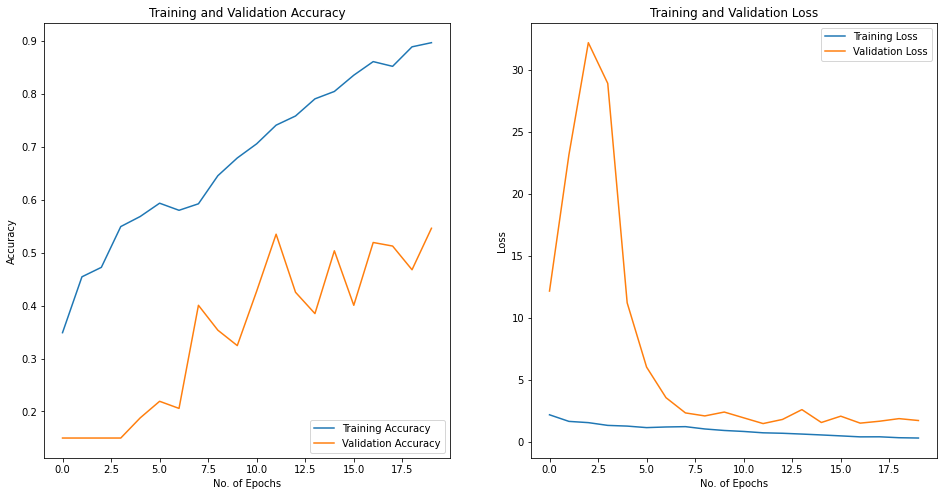

In [ ]:
# Plotting the results
acc = history8.history['accuracy']
val_acc = history8.history['val_accuracy']

loss = history8.history['loss']
val_loss = history8.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy")
plt.xlabel("No. of Epochs")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss")
plt.xlabel("No. of Epochs")

plt.show()

#### Model 8 results after 20 epochs

*   Training accuracy: 0.8962
*   Validation accuracy: 0.5459

- As with model 7, the overfitting is still significant.
- The validation accuracy has remained in the same levels as earlier.

### Model 9

- Same as model 8, but with L2 regularization in one fully connected layer and less harsh dropouts

Architecture:
- Input as per image shape and channels.
- Conv2D(16)
- Batch Norm
- Max_Pooling(2x2)
- Dropout(0.2)
- Conv2D(32)
- Batch Norm
- Max_Pooling(2x2)
- Dropout(0.2)
- Conv2D(64)
- Batch Norm
- Max_Pooling(2x2)
- Dropout(0.3)
- Fully Connected layer (128) + L2 regularization
- Batch Norm
- Dropout (0.5)
- Softmax output layer (9 classes)
- Optimizer: 'adam'
- Loss: 'categorical_crossentropy'

In [ ]:
# Import L2 regularization
from tensorflow.keras.regularizers import l2

In [ ]:
# Model 9
# Same as model 8, but with L2 regularization in one fully connected layer.

model9 = Sequential([layers.Layer(input_shape = (img_height, img_width, 3))])

model9.add(Conv2D(16, kernel_size=(3,3), padding ='same', activation = 'relu'))
model9.add(BatchNormalization())
model9.add(MaxPooling2D(pool_size=(2,2)))
model9.add(Dropout(0.2))

model9.add(Conv2D(32, kernel_size=(3,3), padding ='same', activation = 'relu'))
model9.add(BatchNormalization())
model9.add(MaxPooling2D(pool_size=(2,2)))
model9.add(Dropout(0.2))

model9.add(Conv2D(64, kernel_size=(3,3), padding ='same', activation = 'relu'))
model9.add(BatchNormalization())
model9.add(MaxPooling2D(pool_size=(2,2)))
model9.add(Dropout(0.3))

model9.add(Flatten())
model9.add(Dense(128, activation = 'relu', kernel_regularizer=l2(0.01)))
model9.add(BatchNormalization())
model9.add(Dropout(0.5))
model9.add(Dense(num_classes, activation = 'softmax'))

# View the summary of all layers
model9.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_18 (Layer)             (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
batch_normalization_45 (Batc (None, 180, 180, 16)      64        
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
dropout_47 (Dropout)         (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
batch_normalization_46 (Batc (None, 90, 90, 32)      

In [ ]:
# Compiling model 9
model9.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Fitting model 9
epochs = 20
history9 = model9.fit(train_ds, 
                      validation_data=val_ds,
                      epochs=epochs, 
                      verbose = 1, shuffle = True)

Epoch 1/20
56/56 [==============================] - 5s 62ms/step - loss: 5.3899 - accuracy: 0.3315 - val_loss: 8.6736 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 3s 57ms/step - loss: 3.9239 - accuracy: 0.4637 - val_loss: 8.3099 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 3s 56ms/step - loss: 3.0645 - accuracy: 0.5067 - val_loss: 6.1244 - val_accuracy: 0.2058
Epoch 4/20
56/56 [==============================] - 3s 57ms/step - loss: 2.6738 - accuracy: 0.5363 - val_loss: 4.4377 - val_accuracy: 0.1767
Epoch 5/20
56/56 [==============================] - 3s 56ms/step - loss: 2.4690 - accuracy: 0.5307 - val_loss: 3.5608 - val_accuracy: 0.1253
Epoch 6/20
56/56 [==============================] - 3s 57ms/step - loss: 2.4451 - accuracy: 0.5301 - val_loss: 3.4712 - val_accuracy: 0.2148
Epoch 7/20
56/56 [==============================] - 3s 56ms/step - loss: 2.3669 - accuracy: 0.5698 - val_loss: 3.5463 - val_accuracy: 0.2595
Epoch 8/20
56

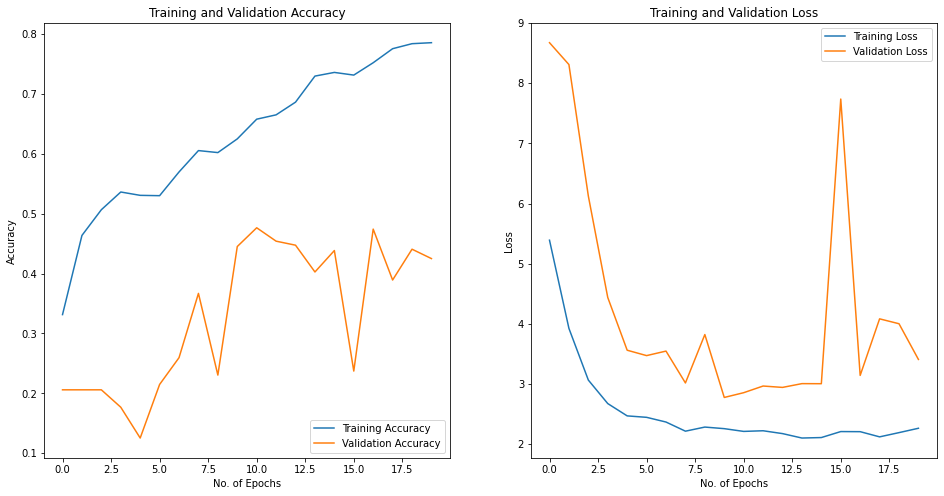

In [ ]:
# Plotting the results
acc = history9.history['accuracy']
val_acc = history9.history['val_accuracy']

loss = history9.history['loss']
val_loss = history9.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy")
plt.xlabel("No. of Epochs")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss")
plt.xlabel("No. of Epochs")

plt.show()

#### Model 9 results after 20 epochs

*   Training accuracy: 0.7857
*   Validation accuracy: 0.4251

- Overfitting is very slightly reduced more because of a reduction in training accuracy, rather than increase of validation accuracy.


### Model 10

- Same as model 9, but with harsher dropout after conv layers and less harsh dropout parameters after fully connected layer .

Architecture:
- Input as per image shape and channels.
- Conv2D(16)
- Batch Norm
- Max_Pooling(2x2)
- Dropout(0.4)
- Conv2D(32)
- Batch Norm
- Max_Pooling(2x2)
- Dropout(0.4)
- Conv2D(64)
- Batch Norm
- Max_Pooling(2x2)
- Dropout(0.4)
- Fully Connected layer (128) + L2 Regularization
- Batch Norm
- Dropout(0.5)
- Softmax output layer (9 classes)
- Optimizer: 'adam'
- Loss: 'categorical_crossentropy'

In [ ]:
# Model 10
# Same as model 9, but with harsher dropout after conv layers.

model10 = Sequential([layers.Layer(input_shape = (img_height, img_width, 3))])

model10.add(Conv2D(16, kernel_size=(3,3), padding ='same', activation = 'relu'))
model10.add(BatchNormalization())
model10.add(MaxPooling2D(pool_size=(2,2)))
model10.add(Dropout(0.4))

model10.add(Conv2D(32, kernel_size=(3,3), padding ='same', activation = 'relu'))
model10.add(BatchNormalization())
model10.add(MaxPooling2D(pool_size=(2,2)))
model10.add(Dropout(0.4))

model10.add(Conv2D(64, kernel_size=(3,3), padding ='same', activation = 'relu'))
model10.add(BatchNormalization())
model10.add(MaxPooling2D(pool_size=(2,2)))
model10.add(Dropout(0.4))

model10.add(Flatten())
model10.add(Dense(128, activation = 'relu', kernel_regularizer=l2(0.01)))
model10.add(BatchNormalization())
model10.add(Dropout(0.5))
model10.add(Dense(num_classes, activation = 'softmax'))

# View the summary of all layers
model10.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_21 (Layer)             (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
batch_normalization_56 (Batc (None, 180, 180, 16)      64        
_________________________________________________________________
max_pooling2d_67 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
dropout_59 (Dropout)         (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
batch_normalization_57 (Batc (None, 90, 90, 32)      

In [ ]:
# Compiling model 10
model10.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Fitting model 10
epochs = 20
history10 = model10.fit(train_ds, 
                      validation_data=val_ds,
                      epochs=epochs, 
                      verbose = 1, shuffle = True)

Epoch 1/20
56/56 [==============================] - 5s 62ms/step - loss: 5.5036 - accuracy: 0.2539 - val_loss: 14.1951 - val_accuracy: 0.1790
Epoch 2/20
56/56 [==============================] - 3s 56ms/step - loss: 4.1248 - accuracy: 0.4113 - val_loss: 14.9232 - val_accuracy: 0.1790
Epoch 3/20
56/56 [==============================] - 3s 56ms/step - loss: 3.2564 - accuracy: 0.4905 - val_loss: 14.9928 - val_accuracy: 0.1790
Epoch 4/20
56/56 [==============================] - 3s 56ms/step - loss: 2.7571 - accuracy: 0.5084 - val_loss: 10.4176 - val_accuracy: 0.1745
Epoch 5/20
56/56 [==============================] - 3s 57ms/step - loss: 2.5480 - accuracy: 0.5234 - val_loss: 8.3483 - val_accuracy: 0.1678
Epoch 6/20
56/56 [==============================] - 3s 57ms/step - loss: 2.3918 - accuracy: 0.5491 - val_loss: 6.7830 - val_accuracy: 0.0805
Epoch 7/20
56/56 [==============================] - 3s 57ms/step - loss: 2.2001 - accuracy: 0.5820 - val_loss: 5.0878 - val_accuracy: 0.1454
Epoch 8/2

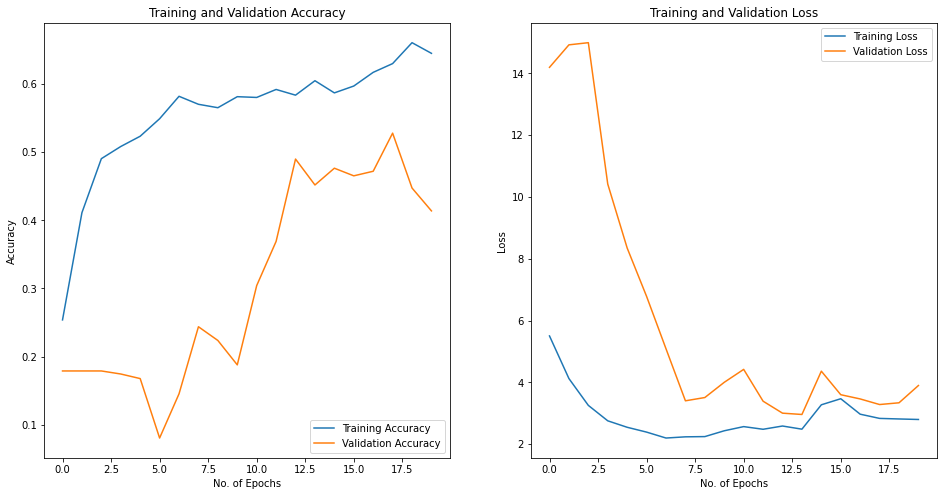

In [ ]:
# Plotting the results
acc = history10.history['accuracy']
val_acc = history10.history['val_accuracy']

loss = history10.history['loss']
val_loss = history10.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy")
plt.xlabel("No. of Epochs")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss")
plt.xlabel("No. of Epochs")

plt.show()

#### Model 10 results after 20 epochs

*   Training accuracy: 0.6451
*   Validation accuracy: 0.4139

- The validation accuracy seems to be plateauing out around 0.5, as with most earlier models.
- It may be a good idea to look at deeper models with the current regularization parameters.

### Model 11

- Same as model 10, but with a deeper network and additional fully connected layer.

Architecture:
- Input as per image shape and channels.
- Conv2D(16)
- Batch Norm
- Max_Pooling(2x2)
- Dropout(0.4)
- Conv2D(32)
- Batch Norm
- Max_Pooling(2x2)
- Dropout(0.4)
- Conv2D(64)
- Batch Norm
- Max_Pooling(2x2)
- Dropout(0.4)
- Conv2D(128)
- Batch Norm
- Max_Pooling(2x2)
- Dropout(0.4)
- Fully Connected layer (128) + L2 Regularization
- Batch Norm
- Fully Connected layer (128) + L2 Regularization
- Batch Norm
- Dropout(0.5)
- Softmax output layer (9 classes)
- Optimizer: 'adam'
- Loss: 'categorical_crossentropy'

In [ ]:
# Model 11
# Same as model 10, but with a deeper network and additional fully connected layer.

model11 = Sequential([layers.Layer(input_shape = (img_height, img_width, 3))])

model11.add(Conv2D(16, kernel_size=(3,3), padding ='same', activation = 'relu'))
model11.add(BatchNormalization())
model11.add(MaxPooling2D(pool_size=(2,2)))
model11.add(Dropout(0.4))

model11.add(Conv2D(32, kernel_size=(3,3), padding ='same', activation = 'relu'))
model11.add(BatchNormalization())
model11.add(MaxPooling2D(pool_size=(2,2)))
model11.add(Dropout(0.4))

model11.add(Conv2D(64, kernel_size=(3,3), padding ='same', activation = 'relu'))
model11.add(BatchNormalization())
model11.add(MaxPooling2D(pool_size=(2,2)))
model11.add(Dropout(0.4))

model11.add(Conv2D(128, kernel_size=(3,3), padding ='same', activation = 'relu'))
model11.add(BatchNormalization())
model11.add(MaxPooling2D(pool_size=(2,2)))
model11.add(Dropout(0.4))

model11.add(Flatten())
model11.add(Dense(256, activation = 'relu', kernel_regularizer=l2(0.01)))
model11.add(BatchNormalization())
model11.add(Dense(512, activation = 'relu', kernel_regularizer=l2(0.01)))
model11.add(BatchNormalization())
model11.add(Dropout(0.5))
model11.add(Dense(num_classes, activation = 'softmax'))

# View the summary of all layers
model11.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_22 (Layer)             (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
batch_normalization_60 (Batc (None, 180, 180, 16)      64        
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
dropout_63 (Dropout)         (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
batch_normalization_61 (Batc (None, 90, 90, 32)      

In [ ]:
# Compiling model 11
model11.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Fitting model 11
epochs = 20
history11 = model11.fit(train_ds, 
                      validation_data=val_ds,
                      epochs=epochs, 
                      verbose = 1, shuffle = True)

Epoch 1/20
56/56 [==============================] - 5s 70ms/step - loss: 10.9019 - accuracy: 0.3594 - val_loss: 10.9584 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 4s 64ms/step - loss: 9.1395 - accuracy: 0.4515 - val_loss: 11.6771 - val_accuracy: 0.1499
Epoch 3/20
56/56 [==============================] - 4s 64ms/step - loss: 7.3357 - accuracy: 0.4894 - val_loss: 10.3443 - val_accuracy: 0.1499
Epoch 4/20
56/56 [==============================] - 4s 64ms/step - loss: 6.0615 - accuracy: 0.5084 - val_loss: 8.2296 - val_accuracy: 0.1499
Epoch 5/20
56/56 [==============================] - 4s 64ms/step - loss: 5.2424 - accuracy: 0.5268 - val_loss: 8.6637 - val_accuracy: 0.1499
Epoch 6/20
56/56 [==============================] - 4s 63ms/step - loss: 4.4656 - accuracy: 0.5424 - val_loss: 5.5910 - val_accuracy: 0.2886
Epoch 7/20
56/56 [==============================] - 4s 63ms/step - loss: 3.9772 - accuracy: 0.5631 - val_loss: 6.5895 - val_accuracy: 0.2819
Epoch 8/2

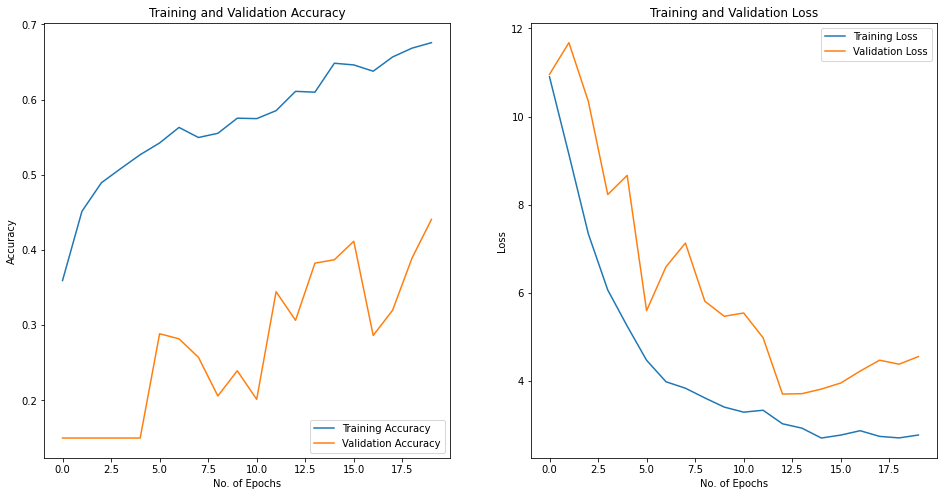

In [ ]:
# Plotting the results
acc = history11.history['accuracy']
val_acc = history11.history['val_accuracy']

loss = history11.history['loss']
val_loss = history11.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy")
plt.xlabel("No. of Epochs")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss")
plt.xlabel("No. of Epochs")

plt.show()

#### Model 11 results after 20 epochs

*   Training accuracy: 0.6758
*   Validation accuracy: 0.4407

- Adding more layers doesn't seem to improve the validation accuracy much.
- The overfitting issue still remains.

### Findings after regularization tests

- Applying regularization (Dropouts + L2 in fully-connected layer) helps with the overfitting issue to some extent encountered with earlier models.
- However, the validation accuracy values are fairly low. There may be a couple of reasons that may be causing this.
  - Image samples in training dataset within a class may be similar to each other. Might call for data augmentation strategies like random flipping, rotation or zoom.
  - Class imbalance: As we have already seen earlier, there is some class imbalance in the dataset. This might be addressed by upsampling the classes with lesser number of data points.
- Both of the above issues might need to be addressed to obtain more useful results.
- Simpler models seem to perform equally well (or poorly) as more complex deeper / wider models. Hence, we shall proceed with simple models initially with augmented data.

### Data Augmentation check

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Data augmentation check
# Since the training data had earlier been normalized (0 to 1), we first rescale the data back to their original pixel values, before visualising the data augmentation.

data_augmentation = Sequential([
                       layers.experimental.preprocessing.Rescaling(1. * 255, input_shape = (img_height, img_width, 3)),
                       layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                       layers.experimental.preprocessing.RandomRotation(0.3),
                       layers.experimental.preprocessing.RandomZoom(0.1)])

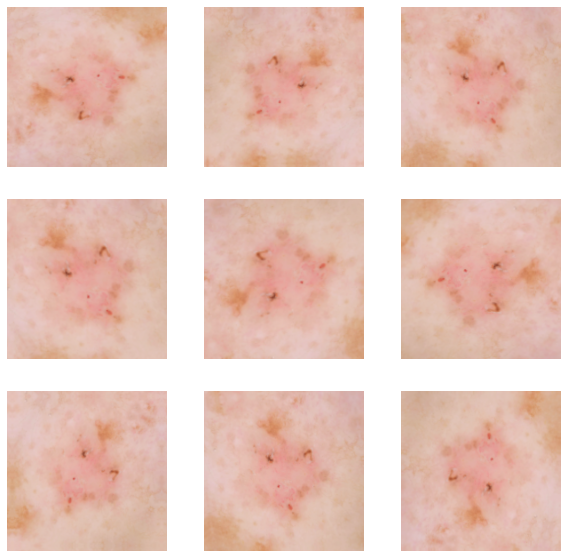

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")
plt.show()

### Todo:
 Create the model, compile and train the model


### Model 12

- Addition of some data augmentation - RandomFlip + RandomRotation + RandomZoom

Architecture:
- Input as per image shape and channels.
- RandomFlip - 'horizontal_and_vertical'
- RandomRotation(0.3)
- RandomZoom(0.1)
- Conv2D(16)
- Batch Norm
- Max_Pooling(2x2)
- Dropout(0.2)
- Conv2D(32)
- Batch Norm
- Max_Pooling(2x2)
- Dropout(0.2)
- Conv2D(64)
- Batch Norm
- Max_Pooling(2x2)
- Dropout(0.3)
- Fully Connected layer (128)
- Batch Norm
- Dropout (0.5)
- Softmax output layer (9 classes)
- Optimizer: 'adam'
- Loss: 'categorical_crossentropy'

In [ ]:
# Model 12
# Additional data augmentation as checked above - RandomFlip + RandomRotation + RandomZoom

model12 = Sequential([layers.Layer(input_shape = (img_height, img_width, 3))])

model12.add(layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"))
model12.add(layers.experimental.preprocessing.RandomRotation(0.3))
model12.add(layers.experimental.preprocessing.RandomZoom(0.1))

model12.add(Conv2D(16, kernel_size=(3,3), padding ='same', activation = 'relu'))
model12.add(BatchNormalization())
model12.add(MaxPooling2D(pool_size=(2,2)))
model12.add(Dropout(0.2))

model12.add(Conv2D(32, kernel_size=(3,3), padding ='same', activation = 'relu'))
model12.add(BatchNormalization())
model12.add(MaxPooling2D(pool_size=(2,2)))
model12.add(Dropout(0.2))

model12.add(Conv2D(64, kernel_size=(3,3), padding ='same', activation = 'relu'))
model12.add(BatchNormalization())
model12.add(MaxPooling2D(pool_size=(2,2)))
model12.add(Dropout(0.3))

model12.add(Flatten())
model12.add(Dense(128, activation = 'relu'))
model12.add(BatchNormalization())
model12.add(Dropout(0.5))
model12.add(Dense(num_classes, activation = 'softmax'))

# View the summary of all layers
model12.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer (Layer)                (None, 180, 180, 3)       0         
_________________________________________________________________
random_flip_1 (RandomFlip)   (None, 180, 180, 3)       0         
_________________________________________________________________
random_rotation_1 (RandomRot (None, 180, 180, 3)       0         
_________________________________________________________________
random_zoom_1 (RandomZoom)   (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 180, 180, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)       

In [ ]:
# Compiling model 12
model12.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [ ]:
# Fitting model 12
epochs = 30
history12 = model12.fit(train_ds, 
                        validation_data=val_ds,
                        epochs=epochs, 
                        verbose = 1, shuffle = True)

Epoch 1/30
56/56 [==============================] - 67s 643ms/step - loss: 2.1123 - accuracy: 0.3666 - val_loss: 10.3651 - val_accuracy: 0.1499
Epoch 2/30
56/56 [==============================] - 2s 32ms/step - loss: 1.7383 - accuracy: 0.4576 - val_loss: 18.9447 - val_accuracy: 0.1499
Epoch 3/30
56/56 [==============================] - 2s 30ms/step - loss: 1.6076 - accuracy: 0.4621 - val_loss: 29.8756 - val_accuracy: 0.1723
Epoch 4/30
56/56 [==============================] - 2s 30ms/step - loss: 1.5474 - accuracy: 0.4967 - val_loss: 34.0558 - val_accuracy: 0.1633
Epoch 5/30
56/56 [==============================] - 2s 30ms/step - loss: 1.4672 - accuracy: 0.4916 - val_loss: 42.6409 - val_accuracy: 0.1387
Epoch 6/30
56/56 [==============================] - 2s 30ms/step - loss: 1.3826 - accuracy: 0.5140 - val_loss: 48.8687 - val_accuracy: 0.1007
Epoch 7/30
56/56 [==============================] - 2s 31ms/step - loss: 1.3829 - accuracy: 0.5301 - val_loss: 49.9881 - val_accuracy: 0.0716
Epoc

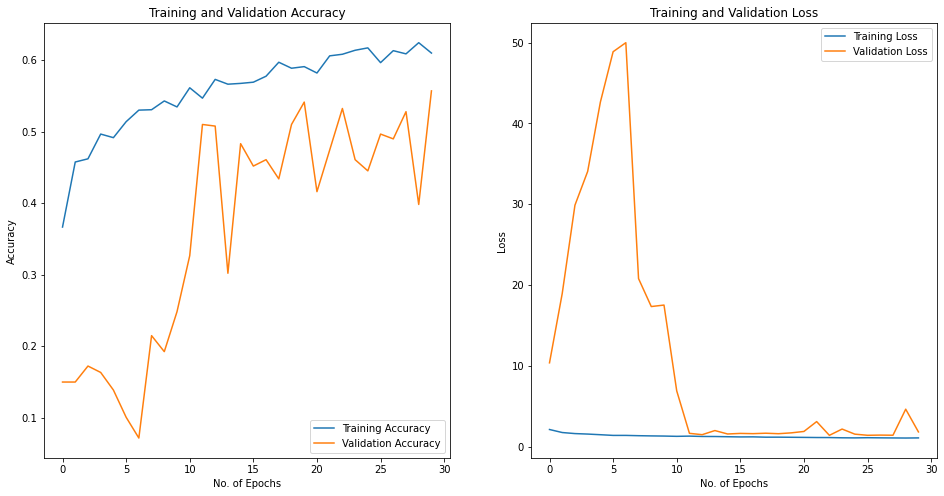

In [ ]:
# Plotting the results
acc = history12.history['accuracy']
val_acc = history12.history['val_accuracy']

loss = history12.history['loss']
val_loss = history12.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy")
plt.xlabel("No. of Epochs")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss")
plt.xlabel("No. of Epochs")

plt.show()

#### Model 12 results after 30 epochs

*   Training accuracy: 0.6099
*   Validation accuracy: 0.5570

- The data augmentation strategies seem to have further reduced overfitting.


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?



### Findings after trying some data augmentation strategies.
- We can see that overfitting issue has largely been addressed using data augmentation and regularization.
- However, accuracies are still rather low.
- This indicates that class imbalance might be playing a bigger role and needs to be addressed.


### Class distribution analysis

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

**Using the dataframe created during EDA earlier to re-visit the class distribution in the dataset.**

In [ ]:
# Displaying the first five rows of the dataframe
df_images.head()

,Image_Name,Label
0,ISIC_0026525.jpg,actinic keratosis
1,ISIC_0025780.jpg,actinic keratosis
2,ISIC_0028190.jpg,actinic keratosis
3,ISIC_0029840.jpg,actinic keratosis
4,ISIC_0025803.jpg,actinic keratosis


In [ ]:
# Checking the distribution of each class, first in numbers
df_images.Label.value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

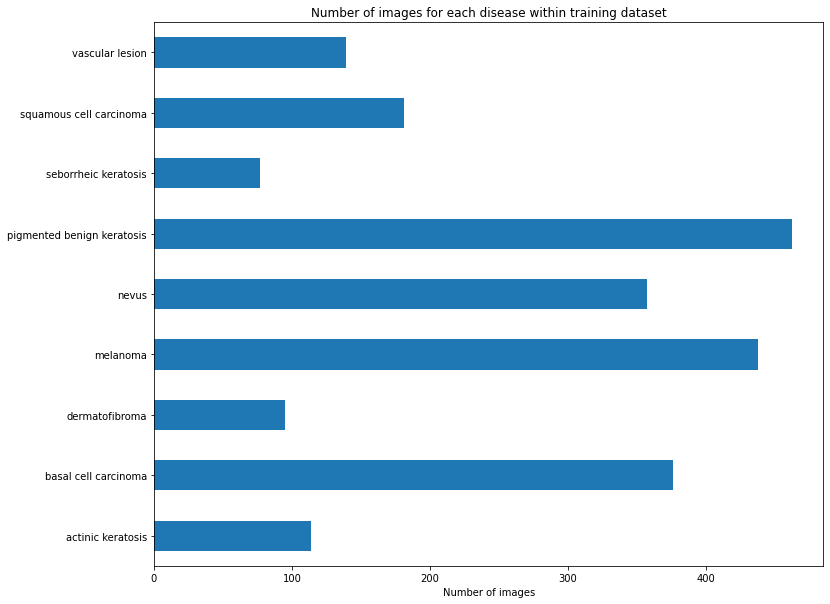

In [ ]:
# Plotting a bar chart of the class distribution
plt.figure(figsize=(12,10))
df_images.Label.value_counts().sort_index().plot.barh()
plt.title("Number of images for each disease within training dataset")
plt.xlabel("Number of images")
plt.show()

#### Conclusions
- We can see some class imbalance in the dataset, with some classes having much larger number of datapoints than others.
- This may affect the training process and would have to be checked if balancing the class distribution helps in the training accuracies.

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?

- The class with the least number of samples is 'seborrheic keratosis', with 77 data samples.

#### - Which classes dominate the data in terms proportionate number of samples?
- The classes with the most number of samples are:
  - pigmented benign keratosis: 462 samples
  - melanoma: 438 samples
  - basal cell carcinoma: 376 samples
  - nevus: 357 samples


### Rectification of class imbalance - Using Augmentor library

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
# Using Augmentor to address class imbalance
path_to_training_dataset = "/content/gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(source_directory= path_to_training_dataset + i)
    # Adding a rotation operation to the pipeline
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F871686E390>: 100%|██████████| 500/500 [00:19<00:00, 26.29 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F87174B08D0>: 100%|██████████| 500/500 [00:18<00:00, 26.88 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8717369B50>: 100%|██████████| 500/500 [00:19<00:00, 26.09 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F87601661D0>: 100%|██████████| 500/500 [01:25<00:00,  5.86 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F87174A6FD0>: 100%|██████████| 500/500 [01:20<00:00,  6.20 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F87169E2310>: 100%|██████████| 500/500 [00:18<00:00, 26.64 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F871776F250>: 100%|██████████| 500/500 [00:41<00:00, 12.08 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8717766390>: 100%|██████████| 500/500 [00:19<00:00, 26.30 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F87176245D0>: 100%|██████████| 500/500 [00:18<00:00, 26.73 Samples/s]


Augmentor has stored the augmented images in the same training directory as earlier. Lets take a look at total count of images - original + augmented.

In [ ]:
image_count_train_new = len(list(data_dir_train.glob("*/*.jpg"))) + len(list(data_dir_train.glob("*/output/*.jpg")))
print("Total images after augmentation (original + augmented): ", image_count_train_new)

Total images after augmentation (original + augmented):  6739


#### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list_new = [x for x in data_dir_train.glob('*/output/*.jpg')]
path_list_new

[PosixPath('/content/gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000317.jpg_caddd761-74df-46f0-9085-078b14246183.jpg'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000464.jpg_1f975200-d170-4143-843a-0310dcd62dbc.jpg'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000490.jpg_1e5216cb-a1bc-4cb3-8234-bd076e546bc7.jpg'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0027896.jpg_23bbc3ab-70d7-4c23-a38e-573821c421c3.jpg'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_000038

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in data_dir_train.glob('*/output/*.jpg')]
lesion_list_new

['nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',


In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
# Dataframe with details of augmented images
df_images2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ["Image_Name","Label"])

# Combined dataframe of details of original and augmented images
new_df = df_images.append(df_images2)

In [ ]:
# Class distribution after augmentation
new_df.Label.value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

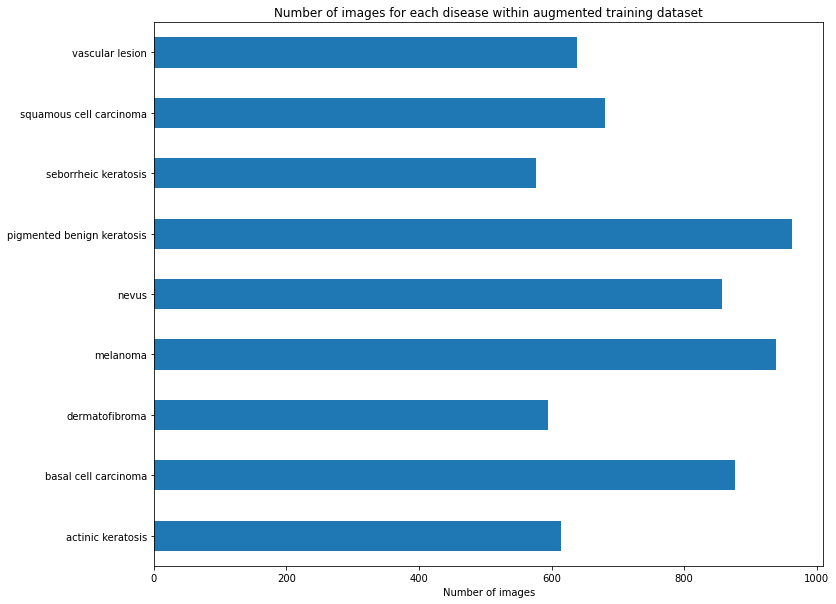

In [ ]:
# Plotting a bar chart of the new class distribution
plt.figure(figsize=(12,10))
new_df.Label.value_counts().sort_index().plot.barh()
plt.title("Number of images for each disease within augmented training dataset")
plt.xlabel("Number of images")
plt.show()

So, now we have added 500 images to all the classes to improve class balance. We can add more images as we want to improve training process.

### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
# Import required library
from tensorflow.keras.utils import image_dataset_from_directory

In [ ]:
train_ds_aug = image_dataset_from_directory(data_dir_train, labels='inferred', label_mode='categorical',
                                            batch_size = batch_size, image_size=(img_height,img_width),
                                            shuffle=True, seed = 123, validation_split=0.2, subset='training')

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [ ]:
val_ds_aug = image_dataset_from_directory(data_dir_train, labels='inferred', label_mode='categorical',
                                           batch_size = batch_size, image_size=(img_height,img_width),
                                           shuffle=True, seed = 123, validation_split=0.2, subset='validation')

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### **Todo:** Create your model (make sure to include normalization)

### Normalizing the augmented dataset.

In [ ]:
# Defining a normalization layer
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
# Applying normalization to training data
train_ds_aug = train_ds_aug.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(train_ds_aug))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.13889101 0.9218937


In [ ]:
# Applying normalization to validation data
val_ds_aug = val_ds_aug.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(val_ds_aug))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.3027779 0.93464047


In [ ]:
# Configuring the dataset for performance, so that I/O does not become a bottleneck
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds_aug = train_ds_aug.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds_aug = val_ds_aug.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
num_classes = 9

### Model 13
Relatively simple architecture with 3 convolution layers and one Fully-Connected layer. 
Using augmented dataset with better class distribution than earlier

Architecture:
- Input as per image shape and channels.
- RandomFlip - 'horizontal_and_vertical'
- RandomRotation(0.1)
- RandomZoom(0.1)
- Conv2D(16)
- Batch Norm
- Max_Pooling(2x2)
- Conv2D(32)
- Batch Norm
- Max_Pooling(2x2)
- Conv2D(64)
- Batch Norm
- Max_Pooling(2x2)
- Dropout(0.3)
- Fully Connected layer (128)
- Batch Norm
- Dropout (0.5)
- Softmax output layer (9 classes)
- Optimizer: 'adam'
- Loss: 'categorical_crossentropy'

In [ ]:
# Model 13
# Relatively simple architecture with 3 convolution layers and one Fully-Connected layer.
# Using augmented dataset with better class distribution than earlier

model13 = Sequential([layers.Layer(input_shape = (img_height, img_width, 3))])

model13.add(layers.experimental.preprocessing.RandomFlip("horizontal"))
model13.add(layers.experimental.preprocessing.RandomRotation(0.1))
model13.add(layers.experimental.preprocessing.RandomZoom(0.1))

model13.add(Conv2D(16, kernel_size=(3,3), padding ='same', activation = 'relu'))
model13.add(BatchNormalization())
model13.add(MaxPooling2D(pool_size=(2,2)))

model13.add(Conv2D(32, kernel_size=(3,3), padding ='same', activation = 'relu'))
model13.add(BatchNormalization())
model13.add(MaxPooling2D(pool_size=(2,2)))

model13.add(Conv2D(64, kernel_size=(3,3), padding ='same', activation = 'relu'))
model13.add(BatchNormalization())
model13.add(MaxPooling2D(pool_size=(2,2)))
model13.add(Dropout(0.3))

model13.add(Flatten())
model13.add(Dense(128, activation = 'relu'))
model13.add(BatchNormalization())
model13.add(Dropout(0.5))
model13.add(Dense(num_classes, activation = 'softmax'))

# View the summary of all layers
model13.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_6 (Layer)              (None, 180, 180, 3)       0         
_________________________________________________________________
random_flip_6 (RandomFlip)   (None, 180, 180, 3)       0         
_________________________________________________________________
random_rotation_6 (RandomRot (None, 180, 180, 3)       0         
_________________________________________________________________
random_zoom_6 (RandomZoom)   (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
batch_normalization_24 (Batc (None, 180, 180, 16)      64        
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 90, 90, 16)       

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
# Compiling model 13
model13.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

#### **Todo:**  Train your model

In [ ]:
# Fitting model 13
epochs = 50
history13 = model13.fit(train_ds_aug, 
                      validation_data=val_ds_aug,
                      epochs=epochs, 
                      verbose = 1, shuffle = True)

Epoch 1/50
169/169 [==============================] - 12s 62ms/step - loss: 1.9957 - accuracy: 0.3557 - val_loss: 8.0634 - val_accuracy: 0.1158
Epoch 2/50
169/169 [==============================] - 10s 61ms/step - loss: 1.6024 - accuracy: 0.4308 - val_loss: 6.4367 - val_accuracy: 0.1967
Epoch 3/50
169/169 [==============================] - 10s 61ms/step - loss: 1.4474 - accuracy: 0.4716 - val_loss: 3.8329 - val_accuracy: 0.2428
Epoch 4/50
169/169 [==============================] - 10s 61ms/step - loss: 1.3173 - accuracy: 0.5109 - val_loss: 1.2365 - val_accuracy: 0.5464
Epoch 5/50
169/169 [==============================] - 10s 61ms/step - loss: 1.2110 - accuracy: 0.5521 - val_loss: 2.3859 - val_accuracy: 0.3742
Epoch 6/50
169/169 [==============================] - 10s 60ms/step - loss: 1.1646 - accuracy: 0.5642 - val_loss: 1.7679 - val_accuracy: 0.4477
Epoch 7/50
169/169 [==============================] - 10s 60ms/step - loss: 1.1767 - accuracy: 0.5658 - val_loss: 1.3292 - val_accuracy:

#### **Todo:**  Visualize the model results

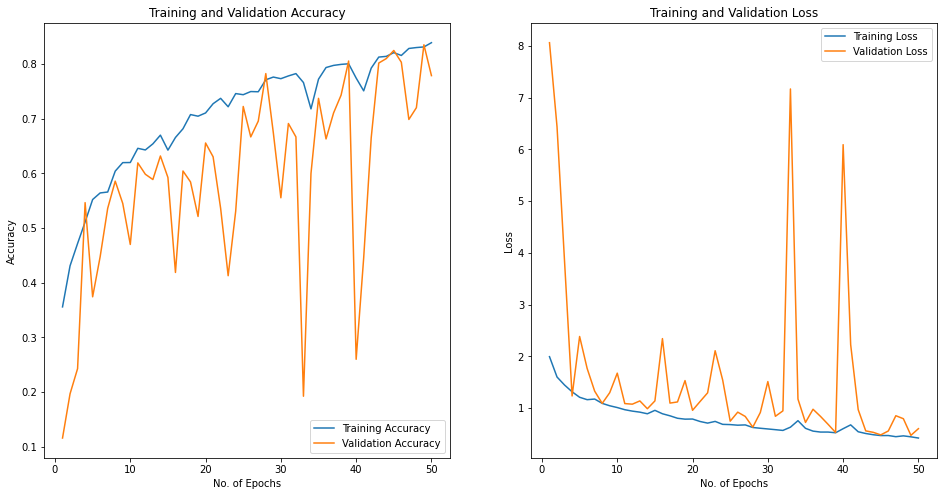

In [ ]:
# Plotting the results
acc = history13.history['accuracy']
val_acc = history13.history['val_accuracy']

loss = history13.history['loss']
val_loss = history13.history['val_loss']

epochs_range = range(1,epochs+1)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy")
plt.xlabel("No. of Epochs")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss")
plt.xlabel("No. of Epochs")

plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



#### Model 13 conclusions after 50 epochs
- Training accuracy: 0.8390
- Validation accuracy: 0.7788
- Much better model using augmented data.
- The training and validation accuracy have increased more or less monotonically with no overfitting.
- The validation accuracy is quite erratic. Perhaps a slower learning rate may be able to address it.


### Model 14

- Same as model 13, but with slower learning rate

Architecture:
- Input as per image shape and channels.
- RandomFlip - 'horizontal_and_vertical'
- RandomRotation(0.1)
- RandomZoom(0.1)
- Conv2D(16)
- Batch Norm
- Max_Pooling(2x2)
- Conv2D(32)
- Batch Norm
- Max_Pooling(2x2)
- Conv2D(64)
- Batch Norm
- Max_Pooling(2x2)
- Dropout(0.3)
- Fully Connected layer (128)
- Batch Norm
- Dropout (0.5)
- Softmax output layer (9 classes)
- Optimizer: 'adam' (Learning rate reduced to 0.0001)
- Loss: 'categorical_crossentropy'

In [ ]:
# Model 14
# Same as model 13, but with milder regularization and slower learning rate

model14 = Sequential([layers.Layer(input_shape = (img_height, img_width, 3))])

model14.add(layers.experimental.preprocessing.RandomFlip("horizontal"))
model14.add(layers.experimental.preprocessing.RandomRotation(0.1))
model14.add(layers.experimental.preprocessing.RandomZoom(0.1))

model14.add(Conv2D(16, kernel_size=(3,3), padding ='same', activation = 'relu'))
model14.add(BatchNormalization())
model14.add(MaxPooling2D(pool_size=(2,2)))

model14.add(Conv2D(32, kernel_size=(3,3), padding ='same', activation = 'relu'))
model14.add(BatchNormalization())
model14.add(MaxPooling2D(pool_size=(2,2)))

model14.add(Conv2D(64, kernel_size=(3,3), padding ='same', activation = 'relu'))
model14.add(BatchNormalization())
model14.add(MaxPooling2D(pool_size=(2,2)))
model14.add(Dropout(0.3))

model14.add(Flatten())
model14.add(Dense(128, activation = 'relu'))
model14.add(BatchNormalization())
model14.add(Dropout(0.5))
model14.add(Dense(num_classes, activation = 'softmax'))

# View the summary of all layers
model14.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_9 (Layer)              (None, 180, 180, 3)       0         
_________________________________________________________________
random_flip_9 (RandomFlip)   (None, 180, 180, 3)       0         
_________________________________________________________________
random_rotation_9 (RandomRot (None, 180, 180, 3)       0         
_________________________________________________________________
random_zoom_9 (RandomZoom)   (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
batch_normalization_36 (Batc (None, 180, 180, 16)      64        
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 90, 90, 16)       

In [ ]:
# Compiling model 14 with a lower learning rate than earlier.
model14.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Fitting model 14
# Increasing epochs since the learning rate has been reduced significantly by a factor of 10.
epochs = 70
history14 = model14.fit(train_ds_aug, 
                      validation_data=val_ds_aug,
                      epochs=epochs, 
                      verbose = 1, shuffle = True)

Epoch 1/70
169/169 [==============================] - 12s 63ms/step - loss: 2.1486 - accuracy: 0.3301 - val_loss: 2.4036 - val_accuracy: 0.1826
Epoch 2/70
169/169 [==============================] - 10s 61ms/step - loss: 1.7314 - accuracy: 0.4260 - val_loss: 2.0204 - val_accuracy: 0.3563
Epoch 3/70
169/169 [==============================] - 10s 61ms/step - loss: 1.5796 - accuracy: 0.4611 - val_loss: 1.2620 - val_accuracy: 0.5509
Epoch 4/70
169/169 [==============================] - 10s 61ms/step - loss: 1.4798 - accuracy: 0.4833 - val_loss: 1.1824 - val_accuracy: 0.5746
Epoch 5/70
169/169 [==============================] - 10s 60ms/step - loss: 1.4204 - accuracy: 0.5121 - val_loss: 1.1321 - val_accuracy: 0.6006
Epoch 6/70
169/169 [==============================] - 10s 61ms/step - loss: 1.3435 - accuracy: 0.5300 - val_loss: 1.1524 - val_accuracy: 0.5887
Epoch 7/70
169/169 [==============================] - 10s 60ms/step - loss: 1.2857 - accuracy: 0.5425 - val_loss: 1.1298 - val_accuracy:

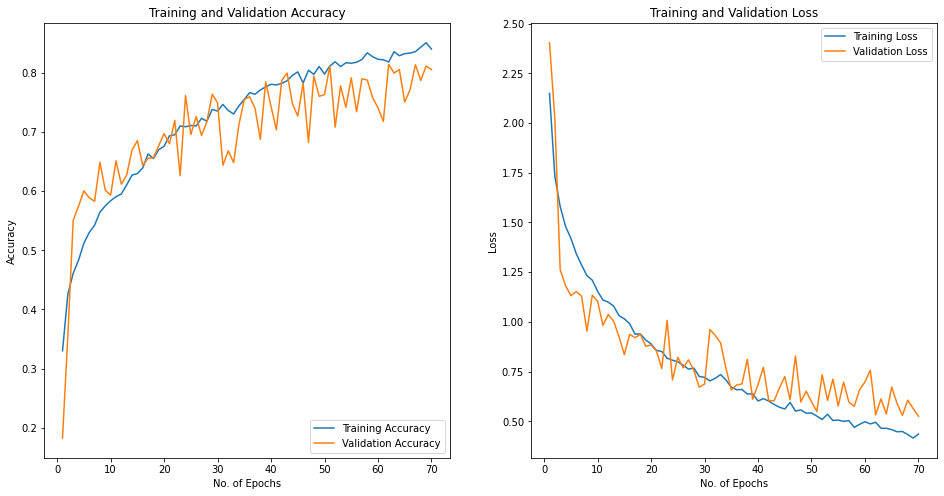

In [ ]:
# Plotting the results
acc = history14.history['accuracy']
val_acc = history14.history['val_accuracy']

loss = history14.history['loss']
val_loss = history14.history['val_loss']

epochs_range = range(1,epochs+1)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy")
plt.xlabel("No. of Epochs")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss")
plt.xlabel("No. of Epochs")

plt.show()

#### Model 14 conclusions after 50 epochs
- Training accuracy: 0.8401
- Validation accuracy: 0.8055

- The training and validation accuracy have increased more or less monotonically and almost neck and neck after 70 epochs. 
- Overfitting has largely been mitigated.
- The reduction in learning rate has meant that the validation accuracy is more stable as compared to earlier models.
- This is a decent model, but let's see if we can improve it further


### Model 15

- Same as model 14, with an additional fully connected layer to check results.
- All batch normalizations have also been removed as a test. Training speed is expected to be slower for this reason.

Architecture:
- Input as per image shape and channels.
- RandomFlip - 'horizontal'
- RandomRotation(0.1)
- RandomZoom(0.1)
- Conv2D(16)
- Max_Pooling(2x2)
- Conv2D(32)
- Max_Pooling(2x2)
- Conv2D(64)
- Max_Pooling(2x2)
- Dropout(0.3)
- Fully Connected layer (128)
- Dropout (0.5)
- Fully Connected layer (256)
- Dropout (0.5)
- Softmax output layer (9 classes)
- Optimizer: 'adam' (Learning rate: 0.0001)
- Loss: 'categorical_crossentropy'

In [ ]:
# Model 15
# Same as model 14, with an additional fully connected layer to check results.
# All batch normalizations have also been removed as a test.

model15 = Sequential([layers.Layer(input_shape = (img_height, img_width, 3))])

model15.add(layers.experimental.preprocessing.RandomFlip("horizontal"))
model15.add(layers.experimental.preprocessing.RandomRotation(0.1))
model15.add(layers.experimental.preprocessing.RandomZoom(0.1))

model15.add(Conv2D(16, kernel_size=(3,3), padding ='same', activation = 'relu'))
model15.add(MaxPooling2D(pool_size=(2,2)))

model15.add(Conv2D(32, kernel_size=(3,3), padding ='same', activation = 'relu'))
model15.add(MaxPooling2D(pool_size=(2,2)))

model15.add(Conv2D(64, kernel_size=(3,3), padding ='same', activation = 'relu'))
model15.add(MaxPooling2D(pool_size=(2,2)))
model15.add(Dropout(0.3))

model15.add(Flatten())
model15.add(Dense(128, activation = 'relu'))
model15.add(Dropout(0.3))
model15.add(Dense(256, activation = 'relu'))
model15.add(Dropout(0.3))
model15.add(Dense(num_classes, activation = 'softmax'))

# View the summary of all layers
model15.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_19 (Layer)             (None, 180, 180, 3)       0         
_________________________________________________________________
random_flip_19 (RandomFlip)  (None, 180, 180, 3)       0         
_________________________________________________________________
random_rotation_19 (RandomRo (None, 180, 180, 3)       0         
_________________________________________________________________
random_zoom_19 (RandomZoom)  (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 90, 90, 32)      

In [ ]:
# Compiling model 15 with a higher learning rate than model 14 because batch norm has been removed.
model15.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Fitting model 15 - Using higher number of epochs because batch norm has been removed, which would likely result in a slower training process.
epochs = 100
history15 = model15.fit(train_ds_aug, 
                      validation_data=val_ds_aug,
                      epochs=epochs, 
                      verbose = 1, shuffle = True)

Epoch 1/100
169/169 [==============================] - 9s 49ms/step - loss: 2.0123 - accuracy: 0.2116 - val_loss: 1.7445 - val_accuracy: 0.3125
Epoch 2/100
169/169 [==============================] - 8s 47ms/step - loss: 1.6292 - accuracy: 0.3767 - val_loss: 1.4112 - val_accuracy: 0.4722
Epoch 3/100
169/169 [==============================] - 8s 47ms/step - loss: 1.5210 - accuracy: 0.4223 - val_loss: 1.4487 - val_accuracy: 0.4514
Epoch 4/100
169/169 [==============================] - 8s 47ms/step - loss: 1.4247 - accuracy: 0.4631 - val_loss: 1.4066 - val_accuracy: 0.4514
Epoch 5/100
169/169 [==============================] - 8s 48ms/step - loss: 1.3707 - accuracy: 0.4707 - val_loss: 1.3040 - val_accuracy: 0.4878
Epoch 6/100
169/169 [==============================] - 8s 48ms/step - loss: 1.3578 - accuracy: 0.4874 - val_loss: 1.3304 - val_accuracy: 0.4937
Epoch 7/100
169/169 [==============================] - 8s 47ms/step - loss: 1.3200 - accuracy: 0.4967 - val_loss: 1.1870 - val_accuracy:

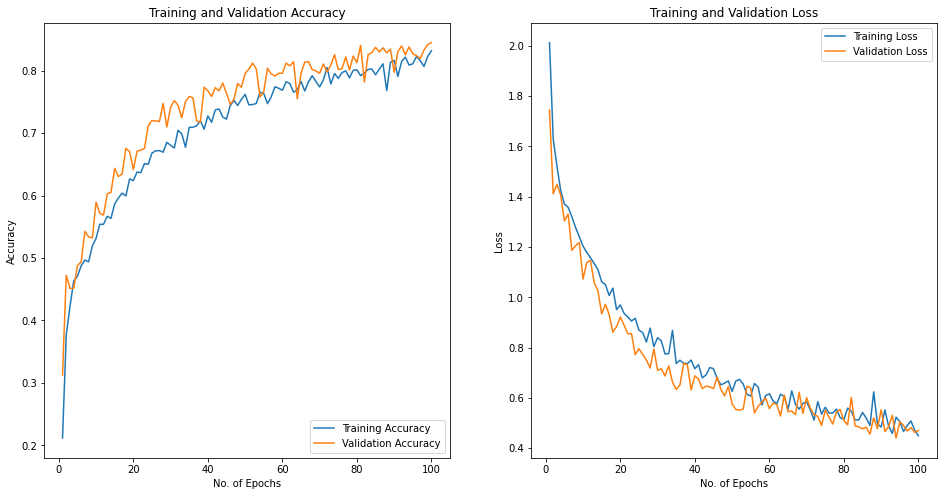

In [ ]:
# Plotting the results
acc = history15.history['accuracy']
val_acc = history15.history['val_accuracy']

loss = history15.history['loss']
val_loss = history15.history['val_loss']

epochs_range = range(1,epochs+1)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy")
plt.xlabel("No. of Epochs")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss")
plt.xlabel("No. of Epochs")

plt.show()

#### Model 15 conclusions after 100 epochs
- Training accuracy: 0.8320
- Validation accuracy: 0.8448

- Removal of Batch Normalization results in much slower training even with a faster learning rate. This is the reason to use much higher epochs than the previous model.
- The additional fully connected layer significantly improves the accuracy.
- Given better hardware resources, there is the potential to further improve this model with more number of epochs.
- There is practically no overfitting with training and validation accuracies being neck and neck throughout the training process.
- This shall be our final model for this assignment due to a paucity of hardware resources. There is certainly scope to further improve the model with deeper networks and more complex architectures.

## Overall Assignment Conclusions and Learnings

- A more complex model does not necessarily mean better results can be achieved. This is especially true if the dataset has class imbalance and small number of data-points, as was the case with our dataset. Occam's razor is a good principle to follow in this regard, i.e., the simplest model which does the job is probably the most suitable model.
- Batch Normalization can significantly speed up the training process. However, it can sometimes make the learning erratic and hence tests should be performed both with and without batch norm.
- Proper regularization strategies like Dropouts make a huge difference in ensuring the model does not overfit. 
- An appropriate data augmentation strategy and balancing class distributions can go a long way in obtaining more accurate models. This is evident from the fact that using augmented data resulted in much better results than the original data (which had significant class imbalance)
